In [1]:
from utils.sam_utils import *
from utils.data_utils import *

C:\Users\Utilisateur\anaconda3\envs\sam_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Utilisateur\anaconda3\envs\sam_env\Lib\site-packages\sam2\modeling\sam\transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [2]:
import os
import gc

def save_checkpoint(masks, checkpoint_s, checkpoint_e, save_dir="pickle_files/pickle_data/"):
    os.makedirs(save_dir, exist_ok=True)
    checkpoint_path = os.path.join(save_dir, f"masks_checkpoint_{checkpoint_s}-{checkpoint_e}.pkl")
    with open(checkpoint_path, 'wb') as f:
        pickle.dump(masks, f)
    print(f"Checkpoint saved at {checkpoint_path}")

def get_masks_batch(images_np, bboxes, batch_size, checkpoint_interval=50):
    masks = []
    for batch_idx, (img_batch, bbox_batch) in enumerate(tqdm(create_batches(images_np, bboxes, batch_size))):
        predictor = load_predictor()
        
        with torch.no_grad():
            predictor.set_image_batch(img_batch)
            masks_batch, _, _ = predictor.predict_batch(
                None,
                None, 
                box_batch=bbox_batch, 
                multimask_output=False
            )
            masks.append(masks_batch)

        del predictor
        del img_batch, bbox_batch, masks_batch  
        torch.cuda.empty_cache()
        free_cpu_memory()
        gc.collect()

    return masks

def display_masks_with_batches(images_np, bboxes, masks, batch_size):
    for (img_batch, bbox_batch), masks_batch in zip(create_batches(images_np, bboxes, batch_size), masks):
        fig, axes = plt.subplots(len(img_batch), 2, figsize=(16, 5*len(img_batch)))
        
        fig.suptitle("Original Image / Image with Masks", fontsize=16)
        
        for i, (image, boxes, batch_masks) in enumerate(zip(img_batch, bbox_batch, masks_batch)):
            axes[i][0].imshow(image)
            axes[i][0].axis("off")
            
            axes[i][1].imshow(image)
            for mask in batch_masks:
                show_mask(mask, axes[i][1], random_color=True)
            for box in boxes:
                show_box(box, axes[i][1])
            axes[i][1].axis("off")
        
        plt.show()


In [3]:
path = 'pickle_files/pickle_data/masks_checkpoint_0-50.pkl'
data = load_pkl_file(path)

In [4]:
checkpoint = 50
batch_size = 16
nb_imgs_display = 5

indexes = slice(
    (checkpoint-1) * batch_size + batch_size - nb_imgs_display,
    (checkpoint) * batch_size,
)

def load_data_items(folder_path):
    images_np = []
    bboxes = []
    for filename in tqdm(os.listdir(folder_path)[indexes]):
        image_path = os.path.join(folder_path, filename)
        image = Image.open(image_path)
        image_np = np.array(image)
        images_np.append(image_np)

        annotation_path = convert_path(image_path, mode='img2txt')
        bbox = load_bboxes(annotation_path, image_np)
        bboxes.append(np.array(bbox))

    return (images_np, bboxes)

In [5]:
images_np, bboxes = load_data_items('data/labelized/images/')

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 58.95it/s]


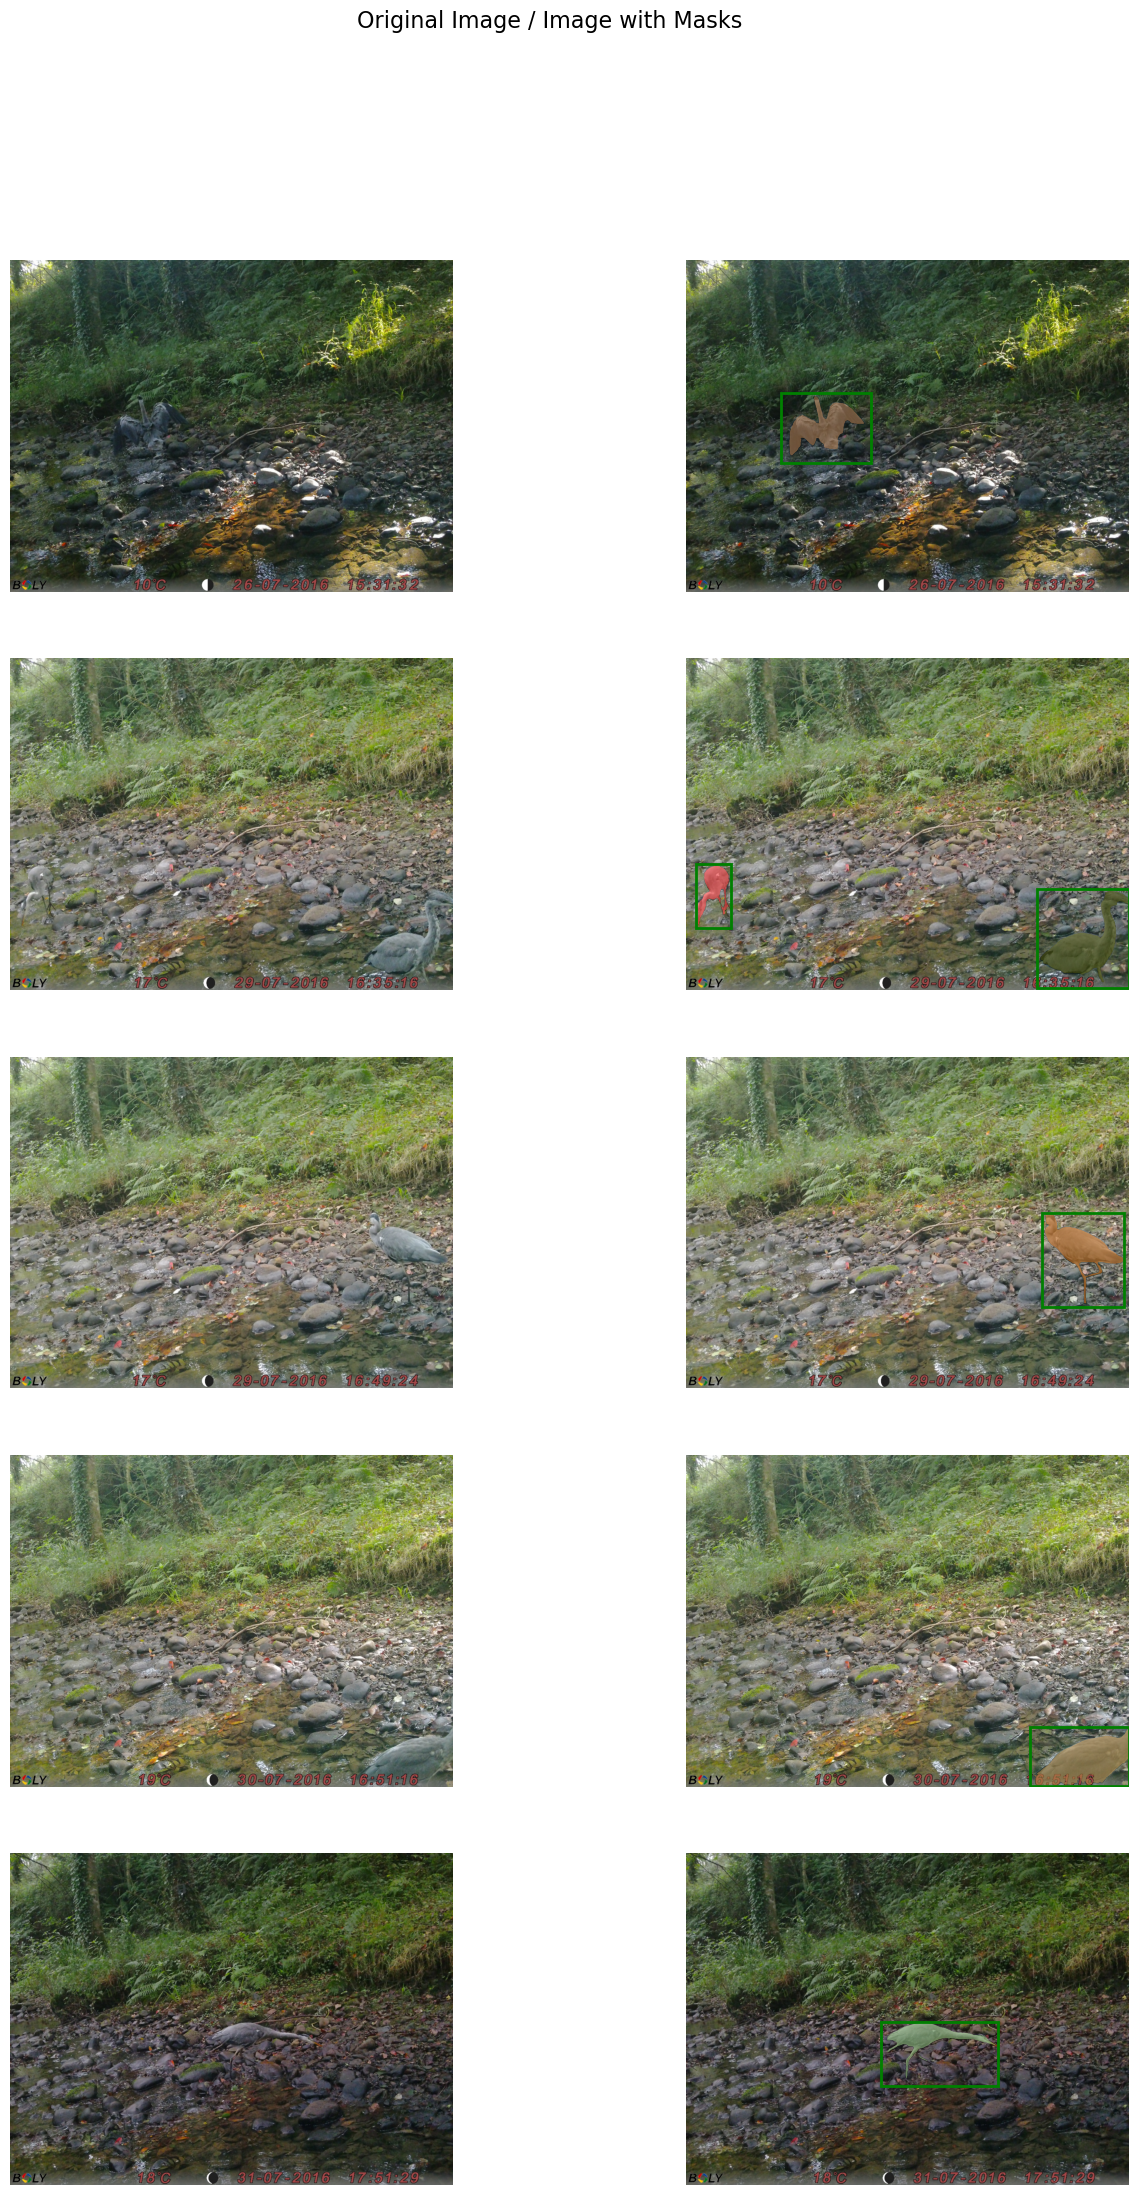

In [6]:
display_masks_with_batches(images_np, bboxes, [data[-1][-nb_imgs_display:]], 16)